<a href="https://colab.research.google.com/github/hostmkmk007/central-pattern-generators/blob/master/CPG%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

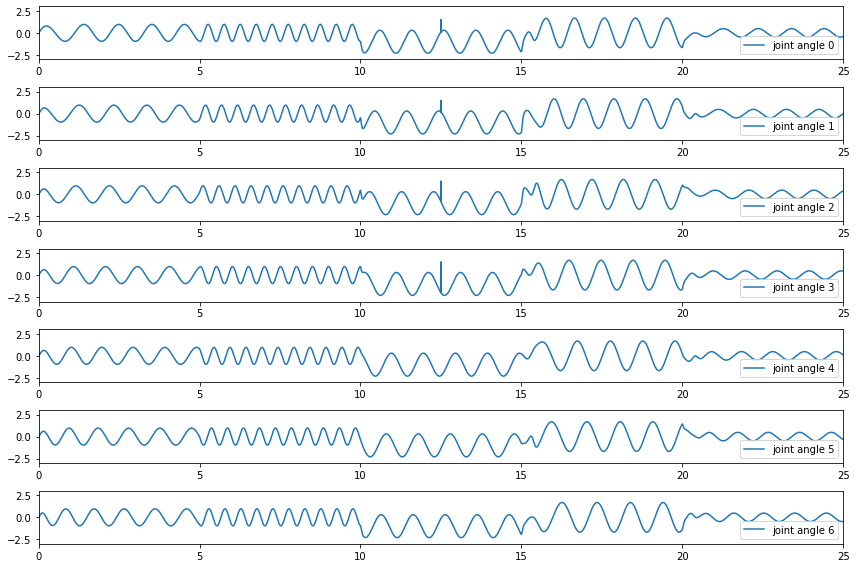

In [1]:
# Reimplemented from [1]
# [1]Crespi, A. and Ijspeert, A.J., 2006. AmphiBot II: An amphibious snake robot that crawls and swims using a central
#    pattern generator. In Proceedings of the 9th international conference on climbing and walking robots (CLAWAR 2006)
#    (No. CONF, pp. 19-27).
# University of York, Yunlong Lian
# April, 2021

import numpy as np
import matplotlib.pyplot as plt

class oscillator():
    """
    One of oscillator in CPG
    Oscillator Class only provide a computing process, it doesn't have any variables.
    """
    def __init__(self, timestep):
        """
        :param timestep:  step size used to calculate the integral, it can be regarded as how many seconds to update the joint angle
        """
        self.t = timestep

    def dy_r2(self, a_i, R_i, pos, dy1):
        dy2 = a_i*(a_i/4*(R_i - pos)-dy1)
        return dy2

    def dy_r1(self, dy1, dy2):
        new_dy1 = dy1 + dy2 * self.t
        return new_dy1

    def update_r(self, pos, dy1):
        p = pos + dy1 * self.t
        return p

    def dy_theta(self, m, n, v_i, weights, thetas, phis):
        sum = 0
        # coupling: between neighbour oscillators are set to delta_phi for the descending connections,
        #           and to -delta_phi for ascending connections
        # m, n is the index of a oscillator
        for i in range(max(0, m-1), min(m+2, len(weights))):
            if i > m:
                phi = -phis[i][n]
            elif i < m:
                phi = phis[i][n]
            else:
                continue
            sum += weights[i][n] * np.sin(thetas[i][n] - thetas[m][n] + phi)
        if n == 0:
            phi = -phis[m][1]
            x = 1
        else:
            phi = phis[m][0]
            x = 0
        sum += weights[m][n] * np.sin(thetas[m][x] - thetas[m][n] + phi)
        dy = 2 * np.pi * v_i + sum
        return dy

    def update_theta(self, theta, dy1):
        new_theta = theta + dy1 * self.t
        return new_theta

    def update_x(self, r_i, theta_i):
        xi = r_i * (1 + np.cos(theta_i))
        return xi

class cpg_fish(oscillator):
    def __init__(self, a_matrix, R_matrix, weights, phase_biases, timestep = 0.001):
        super(cpg_fish, self).__init__(timestep)

        self.t = timestep
        self.a = a_matrix
        self.R = R_matrix

        self.w = weights
        self.phi = phase_biases

        self.r_dy1 =  [[0 for i in range(len(self.w[0]))] for j in range(len(self.w))]
        self.x = [[0 for i in range(len(self.w[0]))] for j in range(len(self.w))]
        self.output_angles = [0 for i in range(len(self.w))]
        # print(self.output_angles)
        # print(self.r_dy1)

    def update_joint(self, i, j, v, r_matrix, theta_matrix):
        """
        To update one joint's oscillator
        :param i:  row index of the oscillator
        :param j:  column index of the oscillator
        :param v:  frequency parameters
        :param r_matrix:  all positions of oscillators
        :param theta_matrix:  all theta of oscillators
        :return: The new value of r[i][j] and theta[i][j]
        """
        # calculate the new position of r[i][j]
        r_dy2 = self.dy_r2(self.a[i][j], self.R[i][j], r_matrix[i][j], self.r_dy1[i][j])
        self.r_dy1[i][j] = self.dy_r1(self.r_dy1[i][j], r_dy2)
        r_ij = self.update_r(r_matrix[i][j], self.r_dy1[i][j])
        # calculate the new position of theta[i][j]
        theta_dy = self.dy_theta(i, j, v, self.w, theta_matrix, self.phi)
        theta_ij = self.update_theta(theta_matrix[i][j], theta_dy)
        # using new r and theta to calculate the new positive output signal
        self.x[i][j] = self.update_x(r_ij, theta_ij)
        return r_ij, theta_ij

    def update_joints(self, r_matrix, theta_matrix, v_matrix):
        """
        To update each oscillator
        :param r_matrix:
        :param theta_matrix:
        :param v_matrix:
        :return: The new values of all r and theta
        """
        for i in range(len(r_matrix)):
            for j in range(len(r_matrix[i])):
                # update each r and theta.
                r_matrix[i][j], theta_matrix[i][j] = self.update_joint(i, j, v_matrix[i][j], r_matrix, theta_matrix)
        return r_matrix, theta_matrix

    def update_angles(self):
        """
        After updated all oscillator, the final thing is to calculate all setpoints according to oscillators
        :return: all setpoints
        """
        for i in range(len(self.x)):
            self.output_angles[i] = self.x[i][0] - self.x[i][1]
        return self.output_angles

    def update_cpg(self, r_matrix, theta_matrix, v_matrix):
        """
        to update the entire CPG, and return state variables, setpoints
        :param r_matrix: state variables of each oscillator
        :param theta_matrix: state variables of each oscillator
        :param v_matrix: control variables, speed
        :return: all r, theta, setpoints
        """
        new_r, new_theta = self.update_joints(r_matrix, theta_matrix, v_matrix)
        output_angles = self.update_angles()
        return new_r, new_theta, output_angles

    def plot_result(self, y, title = None, timestep = None):
        l = len(y)
        if timestep == None:
            t_interval  = 1 / (10 ** (len(str(l))-1))
        else:
            t_interval = timestep
        # print(t_interval)
        t_end = int(l * t_interval)
        # print(t_end)
        t = np.arange(0,t_end,t_interval)
        # print(l,':', t_end, ":", t_interval)
        plt.figure(figsize= (15, 6))
        plt.plot(t, y)
        if title != None:
            plt.title(str(title))
        plt.show()

    def plot_results(self, y, label, ylim, timestep = None):
        l = len(y[0])
        if timestep == None:
            t_interval  = 1 / (10 ** (len(str(l))-1))
        else:
            t_interval = timestep
        # print(t_interval)
        t_end = int(l * t_interval)
        # print(t_end)
        t = np.arange(0, t_end, t_interval)
        num = len(y)
        plt.figure(figsize=(12, 8))
        for i in range(len(y)):
            plt.subplot(num, 1, i+1)
            plt.plot(t, y[i], label=label[i])
            plt.axis([0, t_end, ylim[0], ylim[1]])
            plt.legend(loc = "lower right")
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # In the paper,
    # They chose all R,v, weights, phase baises to be equal for all oscillators

    a_matrix = [[100 for i in range(2)] for j in range(7)]

    R_matrix = [[1 for i in range(2)] for j in range(7)]

    # standing
    R_matrix_standing = [[0 for i in range(2)] for j in range(7)]

    v_matrix = [[1 for i in range(2)] for j in range(7)]

    w_matrix = [[4 for i in range(2)] for j in range(7)]

    phi_matrix = [[1 for i in range(2)] for j in range(7)]

    r_matrix = [[0.5 for i in range(2)] for j in range(7)]

    theta_matrix = [[1 for i in range(2)] for j in range(7)]

    # print(theta_matrix)
    cpg = cpg_fish(a_matrix, R_matrix, w_matrix, phi_matrix, 0.001)
    # Update the CPG firstly
    # r, theta, angles = cpg.update_cpg(r_matrix, theta_matrix)
    # Then, we can get all joints angle
    # print(angles)
    # print("r_dy1: ", cpg.r_dy1)

    old_r = r_matrix
    old_theta = theta_matrix
    angs = [[] for j in range(7)]
    xs = [[] for j in range(14)]
    thetas = [[] for j in range(14)]
    r0 = []
    for i in range(25000):
        if i == 5000:
            v_matrix = [[2 for i in range(2)] for j in range(7)]
            cpg.R = R_matrix
            # cpg.R = R_matrix_standing
        elif i == 10000:
            R_matrix = [[0.5+i for i in range(2)] for j in range(7)]
            v_matrix = [[1 for i in range(2)] for j in range(7)]
            # print(R_matrix)
            cpg.R = R_matrix
            # cpg.R = R_matrix_standing
        elif i == 15000:
            R_matrix = [[1 for i in range(2)] for j in range(7)]
            phi_matrix = [[-2 for i in range(2)] for j in range(7)]
            cpg.R = R_matrix
            cpg.phi = phi_matrix
        elif i == 20000:
            R_matrix = [[0.5 for i in range(2)] for j in range(7)]
            phi_matrix = [[1 for i in range(2)] for j in range(7)]
            cpg.R = R_matrix
            cpg.phi = phi_matrix
        r, theta, angles = cpg.update_cpg(old_r, old_theta, v_matrix)
        # print("theta: ", theta)
        old_r = r
        old_theta = theta
        old_angles = angles
        # perturbation
        if i == 12500:
            old_angles[0] = 1.5
            old_angles[1] = 1.5
            old_angles[2] = 1.5
            old_angles[3] = 1.5
        for k in range(7):
            angs[k].append(angles[k])
            for m in range(2):
                xs[k+m*7].append(cpg.x[k][m])
                thetas[k+m*7].append(theta[k][m])
        r0.append(r[0][0])
        #print(angles)

    labels = ['joint angle 0', 'joint angle 1', 'joint angle 2', 'joint angle 3',
              'joint angle 4', 'joint angle 5', 'joint angle 6']
    ylim = [-3, 3]
    cpg.plot_results(angs, labels, ylim, 0.001)

    # print(angs[0])
    # cpg.plot_result(angs[0], 'angle[0]', 0.001)
    # cpg.plot_result(xs[0], 'x[0]', 0.001)
    # cpg.plot_result(r0, 'r[0]', 0.001)

    # labels = ['x[0]', 'x[1]', 'x[2]', 'x[3]','x[4]', 'x[5]', 'x[6]',
    #           'x[7]', 'x[8]', 'x[9]', 'x[10]','x[11]', 'x[12]', 'x[13]']
    # labels = ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]']
    # ylim = [-0.5, 2.5]
    # cpg.plot_results(xs[:7], labels, ylim, 0.001)
    #
    # labels = ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]']
    # ylim = [-20, 150]
    # cpg.plot_results(thetas[:7], labels, ylim, 0.001)

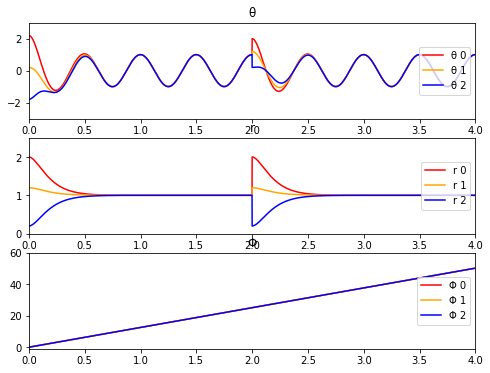

In [2]:
# Reimplemented from [1]
# [1]Crespi, A., Lachat, D., Pasquier, A. and Ijspeert, A.J., 2008. Controlling swimming and crawling in a fish robot
#    using a central pattern generator. Autonomous Robots, 25(1), pp.3-13.
# University of York, Yunlong Lian
# April, 2021

import matplotlib.pyplot as plt
import numpy as np

class oscillator():
    def __init__(self, ss, ar, ax, R, X, r_0, x_0):
        self.stepsize = ss
        self.ax = ax
        self.ar = ar

        self.R = R
        self.r_dy1 = 0
        self.r_dy2 = 0
        self.r = r_0

        self.X = X
        self.x_dy1 = 0
        self.x_dy2 = 0
        self.x = x_0

    def update_r_2(self, r_position, r_dy1, stepsize):
        pos = r_position
        dy1 = r_dy1
        dt = stepsize

        # Get the r''
        dy2 =  ((self.ar * self.ar) / 4) * (self.R - pos) - self.ar * dy1
        # Get the r'
        dy1 += dy2 * dt
        # Get the r
        pos += dy1 * dt

        # update all parameters
        self.r = pos
        self.r_dy1 = dy1
        self.r_dy2 = dy2

        return pos

    def update_x_2(self, x_position, x_dy1, stepsize):
        pos = x_position
        dy1 = x_dy1
        dt = stepsize

        # Get the r''
        dy2 =  ((self.ax * self.ax) / 4) * (self.R - pos) - self.ax * dy1
        # Get the r'
        dy1 += dy2 * dt
        # Get the r
        pos += dy1 * dt

        # update all parameters
        self.x = pos
        self.x_dy1 = dy1
        self.x_dy2 = dy2

        return pos

    def update_r(self, p):
        pos = p
        # dy1 = r_dy1
        # times = stepsize

        # Get the r''
        # self.r_dy2 = (((self.ar*self.ar)/4) * (self.R-pos) - self.ar*self.r_dy1) * self.stepsize
        self.r_dy2 = (((self.ar * self.ar) / 4) * (self.R - pos) - self.ar * self.r_dy1)
        # Get the r'
        self.r_dy1 += self.r_dy2 * self.stepsize
        # Get the r
        pos += self.r_dy1 * self.stepsize
        self.r = pos

        return pos

    def update_x(self, p):
        pos = p
        # Get the r''
        self.x_dy2 = ((self.ax * self.ax) / 4) * (self.X-pos) - self.ax*self.x_dy1
        # Get the r'
        self.x_dy1 += self.x_dy2 * self.stepsize
        # Get the r
        pos += self.x_dy1 * self.stepsize
        # update the r's position
        self.x = pos
        return pos

class Fish_cpg1():
    def __init__(self, omega, ss, ar, ax, R, X, r, x, phi):
        """
        :param omega: (list)  desired frequency
        :param ss:    (number) step size, 1/dt
        :param ar:    (number) constant positive gains
        :param ax:    (number) constant positive gains
        :param R:     (list)   desired amplitude
        :param X:     (list)   desired offset
            For example:
            R = [R0, R1, R2]
            X = [X0, X1, X2]
        :param r:     (list)   state variable
        :param x:     (list)   state variable
            The r and x variables are initial positions of amplitude and offset,
            which will asymptotically and monotonically converge to R and X.
            For example:
            r = [r0, r1, r2]
            x = [x0, x1, x2]
        :param phi:   (list)   state variable
        """
        self.stepsize = ss
        # Three oscillators for three fins
        self.osc = [0,1,2]
        self.osc[0] = oscillator(ss, ar, ax, R[0], X[0], r[0], x[0])
        self.osc[1] = oscillator(ss, ar, ax, R[1], X[1], r[1], x[1])
        self.osc[2] = oscillator(ss, ar, ax, R[2], X[0], r[2], x[2])

        self.theta = [0,0,0]

        # state variable
        self.phi = phi

        self.omega = omega

        self.coupling_w = [[0,0.5,0.5],
                           [0.5,0,0.5],
                           [0.5,0.5,0]]
        self.coupling_phi = [[0,0,0],
                             [0,0,0],
                             [0,0,0]]

    def update_r(self):
        for osc in self.osc:
            osc.update_r(osc.r)
        all_osc_r = [self.osc[0].r, self.osc[0].r, self.osc[0].r]
        return all_osc_r

    def update_x(self):
        for osc in self.osc:
            osc.update_x(osc.x)
        all_osc_x = [self.osc[0].x, self.osc[0].x, self.osc[0].x]
        return all_osc_x

    def update_phi(self):
        """
        before update phi, the "r" and "x" should be updated firstly
        """

        dy_phi = [0,0,0]
        sum = [0,0,0]

        # calculate all dy_phi
        for i in range(len(self.phi)):
            for j in range(len(self.phi)):
                sum[i] += self.coupling_w[i][j] * self.osc[j].r * \
                        np.sin(self.phi[j] - self.phi[i] - self.coupling_phi[i][j])
            dy_phi[i] = self.omega[i] + sum[i]

        # update all the phi
        for i in range(len(self.phi)):
            self.phi[i] += dy_phi[i] * self.stepsize

        return self.phi

    def update_setpoints(self):
        """
        before update setpoints, we should update phi firstly
        """

        for i in range(len(self.theta)):
            self.theta[i] = self.osc[i].x + self.osc[i].r * np.cos(self.phi[i])
        return self.theta

    def set_parameters(self, desired_phi, desired_R, desired_X):
        """
        :param desired_phi: list -- length 3
        :param desired_R: list -- length 3
        :param desired_X: list -- length 3
        :return: None
        """
        self.phi = desired_phi
        for i in range(len(phi)):
            self.osc[i].R = desired_R[i]
            self.osc[i].X = desired_X[i]
            self.phi[i] = phi[i]


    def update_all(self, phi, ri, xi):
        """
        update all things and output all setpoints as a list
        """
        if len(phi) == len(ri) == len(xi) == 3:
            for i in range(len(phi)):
                self.osc[i].r = ri[i]
                self.osc[i].x = xi[i]
                self.phi[i] = phi[i]

        self.update_r()
        self.update_x()
        self.update_phi()
        setpoints = self.update_setpoints()

        return setpoints

    def plot_result(self, y):
        l = len(y)
        t_interval  = 1 / (10 ** (len(str(l))-1))
        # print(t_interval)
        t_end = int(l * t_interval)
        # print(t_end)
        t = np.arange(0,t_end,t_interval)
        # print(l,':', t_end, ":", t_interval)
        plt.figure()
        plt.plot(t, y)
        plt.show()

    def plot_results(self, y1, y2, y3, num, label, title):
        l = len(y1[0])
        t_interval = 1 / (10 ** (len(str(l)) - 1))
        # print(t_interval)
        t_end = int(l * t_interval)
        # print(t_end)
        t = np.arange(0, t_end, t_interval)
        # print(l,':', t_end, ":", t_interval)
        plt.figure(figsize=(8,6))
        plt.subplot(num + 0)
        plt.plot(t, y1[0], color='red', label=label[0][0])
        plt.plot(t, y1[1], color='orange', label=label[0][1])
        plt.plot(t, y1[2], color='blue', label=label[0][2])
        plt.axis([0, t_end, -3, 3])
        plt.title(title[0])
        plt.legend(loc = "right")
        plt.subplot(num + 1)
        plt.plot(t, y2[0], color='red', label=label[1][0])
        plt.plot(t, y2[1], color='orange', label=label[1][1])
        plt.plot(t, y2[2], color='blue', label=label[1][2])
        plt.axis([0, t_end, 0, 2.5])
        plt.title(title[1])
        plt.legend(loc = "right")
        plt.subplot(num + 2)
        plt.plot(t, y3[0], color='red', label=label[2][0])
        plt.plot(t, y3[1], color='orange', label=label[2][1])
        plt.plot(t, y3[2], color='blue', label=label[2][2])
        plt.axis([0, t_end, -1, 60])
        plt.title(title[2])
        plt.legend(loc = "right")
        # plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    # Test oscillator
    osc1 = oscillator(0.001, 20, 20, 1, 0, 2, 0)
    omeg = [np.pi*4, np.pi*4, np.pi*4]
    R_list = [1,1,1]
    X_list = [0,0,0]

    ri = [2, 1.2, 0.2]
    xi = [0.2, -1, -2]

    phi = [0,0,0]
    test_cpg = Fish_cpg1(omeg, 0.001, 20, 20, R_list, X_list, ri, xi, phi)
                    # omega, stpesize, ar, ax, R, X,
    pos = 2
    y = []
    y_phi = [[],[],[]]
    y_r = [[],[],[]]
    theta = [[],[],[]]
    # for i in range(4000):
    #     if i == 2000:
    #         osc1.r = 2
    #     osc1.update_r(osc1.r)
    #     print(osc1.r)
    #     y.append(osc1.r)
    #print(y)
    # test_cpg.plot_result(y)
    for i in range(4000):
        if i == 2000:
            test_cpg.osc[0].r = 2
            test_cpg.osc[1].r = 1.2
            test_cpg.osc[2].r = 0.2
        # First method to update
        # This is to plot the result
        test_cpg.update_x()
        test_cpg.update_r()
        phi_pos = test_cpg.update_phi()
        theta_v = test_cpg.update_setpoints()

        # Second method to update
        # controller send the control parameters using set_parameters()
        # test_cpg.set_parameters(Phi, R, X)
        # receive the state variables to update next motion
        # theta_v = test_cpg.update_all(phi, r, x)

        y_r[0].append(test_cpg.osc[0].r)
        y_r[1].append(test_cpg.osc[1].r)
        y_r[2].append(test_cpg.osc[2].r)

        y_phi[0].append(test_cpg.phi[0])
        y_phi[1].append(test_cpg.phi[1])
        y_phi[2].append(test_cpg.phi[2])

        theta[0].append(theta_v[0])
        theta[1].append(theta_v[1])
        theta[2].append(theta_v[2])

    label = [['θ 0', 'θ 1', 'θ 2'],
             ['r 0', 'r 1', 'r 2'],
             ['Φ 0', 'Φ 1', 'Φ 2']]
    title = ['θ', 'r', 'Φ']
    test_cpg.plot_results(theta, y_r, y_phi, 311, label, title)
    # 311: three picutres(3), one picture per line(1), first picture number(1)

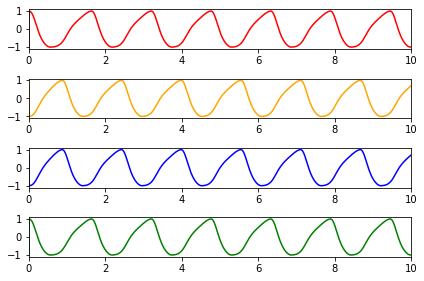

In [3]:
# Reimplemented from [1]
# [1]Righetti, L. and Ijspeert, A.J., 2008, May.
#    Pattern generators with sensory feedback for the control of quadruped locomotion.
#    In 2008 IEEE International Conference on Robotics and Automation (pp. 819-824). IEEE.
# University of York, Yunlong Lian
# April, 2021

import math as m
import numpy as np
import matplotlib.pyplot as  plt

class cpg_hopf():
    def __init__(self,alpha, beta, mu, omega_stance, omega_swing, b):
        self.alpha = alpha
        self.beta = beta
        self.mu = mu
        self.omega_stance = omega_stance
        self.omega_swing = omega_swing
        self.b = b
        self.pos = [1,1]

    def hopf(self,x, y, steps = 0.001):
        self.r_2 = x ** 2 + y ** 2
        #print(self.b*y)
        omega1 = self.omega_stance / (m.exp(-self.b * y) + 1)
        omega2 = self.omega_swing / (m.exp(self.b * y) + 1)
        # print(m.exp(-self.b * y))

        self.omega = omega1 + omega2
        dx = self.alpha * (self.mu - self.r_2) * x - self.omega * y
        dy = self.beta * (self.mu - self.r_2) * y + self.omega * x
        return [x + dx*steps, y + dy*steps]

    def get_trajectory(self, pos, data_number = 5000):
        x = []
        y = []
        px = pos[0]
        py = pos[1]
        for i in range(data_number):
            position = self.hopf(px, py)
            px = position[0]
            py = position[1]
            x.append(position[0])
            y.append(position[1])
        return x,y

class cpg(object):
    def __init__(self,alpha, beta, mu, omega_stance, omega_swing, b):
        self.cm = [[0, -1, -1, 1], [-1, 0, 1, -1],  # coupling_matrix
                   [-1, 1, 0, -1], [1, -1, -1, 0]]
        self.alpha = alpha
        self.beta = beta
        self.mu = mu
        self.omega_stance = omega_stance
        self.omega_swing = omega_swing
        self.b = b
        self.pos = [1,1]

    def hopf(self,x, y, steps = 0.001):
        self.r_2 = x ** 2 + y ** 2
        #print(self.b*y)
        omega1 = self.omega_stance / (m.exp(-self.b * y) + 1)
        omega2 = self.omega_swing / (m.exp(self.b * y) + 1)
        # print(m.exp(-self.b * y))
        self.omega = omega1 + omega2

        dx = self.alpha * (self.mu - self.r_2) * x - self.omega * y
        dy = self.beta * (self.mu - self.r_2) * y + self.omega * x

        return [x + dx*steps, y + dy*steps]

    def coupling(self, cells, steps = 0.001):
        # all_legs are defined as following:
        # all_legs = [[leg0_x,leg0_y], [leg1_x,leg1_y],
                    # [leg2_x,leg2_y], [leg3_x,leg3_y]]
        x = []
        y = []
        new_cells = []
        for i in range(len(cells)):
            x.append(cells[i][0])
            y.append(cells[i][1])
        # print("x: ", x)
        # print("y: ", y)
        if len(cells) != len(self.cm):
            raise ValueError("Error, the number of legs should be equal to the column number of coupling matrics")

        for i in range(len(cells)):
            for j in range(len(self.cm[0])):
                cells[i][1] += self.cm[i][j]*cells[j][1]*steps        # yi
            new_cells.append(cells[i])

        return new_cells

    def get_trajectory(self, pos, data_number = 5000):
        x = []
        y = []
        px = pos[0]
        py = pos[1]
        for i in range(data_number):
            position = self.hopf(px, py)
            px = position[0]
            py = position[1]
            x.append(position[0])
            y.append(position[1])
        return x,y

    def get_all_trajectory(self, data_number = 5000):
        cells = []
        cell = []
        # l1_x = pos[0]
        # l1_y = pos[1]
        # l2_x = pos[0]
        # l2_y = pos[1]
        # l3_x = pos[0]
        # l3_y = pos[1]
        # l4_x = pos[0]
        # l4_y = pos[1]

        l1_x = 1
        l1_y = 0
        l2_x = -1
        l2_y = 0
        l3_x = -1
        l3_y = 0
        l4_x = 1
        l4_y = 0

        cell.append([l1_x,l1_y])
        cell.append([l2_x,l2_y])
        cell.append([l3_x,l3_y])
        cell.append([l4_x,l4_y])
        cells.append(cell)

        for i in range(data_number-1):
            l1_pos = self.hopf(l1_x, l1_y)
            l2_pos = self.hopf(l2_x, l2_y)
            l3_pos = self.hopf(l3_x, l3_y)
            l4_pos = self.hopf(l4_x, l4_y)
            cell[0] = l1_pos
            cell[1] = l2_pos
            cell[2] = l3_pos
            cell[3] = l4_pos
            new_cell = self.coupling(cell)
            # print(new_cell)
            l1_x = new_cell[0][0]
            l1_y = new_cell[0][1]
            l2_x = new_cell[1][0]
            l2_y = new_cell[1][1]
            l3_x = new_cell[2][0]
            l3_y = new_cell[2][1]
            l4_x = new_cell[3][0]
            l4_y = new_cell[3][1]

            cells.append(new_cell)
        return cells

if __name__ == '__main__':
    # coupling_matrix = [[0,-1,-1, 1], [-1, 0, 1, -1], [-1, 1, 0, -1], [1, -1, -1, 0]]

    # test hopf oscillator
    # cpg = cpg_hopf(100, 100, 9, np.pi*2, np.pi*2, 50)
    # x1, x2 = cpg.get_trajectory([1,1])
    # cpg2 = cpg_hopf(100, 100, 1, np.pi*2, np.pi*2, 50)
    # x3, x4 = cpg2.get_trajectory([1, 1])
    # # plot the values of two oscillators
    # t = np.arange(0, 5, 0.001)
    # fig1 = plt.figure()
    # plt.plot(t, x1)  # x of the first oscillator
    # plt.plot(t, x2)  # y of the first oscillator
    # plt.plot(t, x3)  # x of the second oscillator
    # plt.show()
    # fig3 = plt.figure()
    # plt.axis('equal')
    # plt.plot(x1,x2)
    # plt.show()

    # test for coupling
    # legs = [[1,2], [3,4],
    #         [5,6], [7,8]]
    # print(legs)
    # cpg_coupling = cpg(100, 100, 9, np.pi*2, np.pi*2, 50)
    # c = cpg_coupling.coupling(legs, 0.001)
    # print(c)

    # cpg1 = cpg(100, 100, 9, np.pi*2, np.pi*2, 50)
    # x1, x2 = cpg1.get_trajectory([1,1])
    # cpg2 = cpg(100, 100, 1, np.pi*2, np.pi*2, 50)
    # x3, x4 = cpg2.get_trajectory([1, 1])
    # # plot the values of two oscillators
    # t = np.arange(0, 5, 0.001)
    # fig1 = plt.figure()
    # plt.plot(t, x1)  # x of the first oscillator
    # plt.plot(t, x2)  # y of the first oscillator
    # plt.plot(t, x3)  # x of the second oscillator
    # plt.show()
    # fig3 = plt.figure()
    # plt.axis('equal')
    # plt.plot(x1,x2)
    # plt.show()

    # test_cpg = cpg(100, 100, 9, np.pi*2, np.pi*2, 50)
    # # test for coupling:
    # cells = []
    # l1 = test_cpg.hopf(1,1)
    # print(l1)
    # cells.append(l1)
    # l2 = test_cpg.hopf(1, 2)
    # print(l2)
    # cells.append(l2)
    # l3 = test_cpg.hopf(1, 3)
    # print(l3)
    # cells.append(l3)
    # l4 = test_cpg.hopf(1, 4)
    # print(l4)
    # cells.append(l4)
    # coupled = test_cpg.coupling(cells)
    # print("coupled: ", coupled)

    # test for coupled cpg
    ccpg = cpg(100, 100, 1, np.pi*2, np.pi, 50)
    cells_trace = ccpg.get_all_trajectory(10000)
    # print(cells_trace[0][0][0])
    # print(len(cells_trace[0][0]))
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    t = np.arange(0, 10, 0.001)
    for j in range(len(cells_trace)):
        x1.append(cells_trace[j][0][0])
        x2.append(cells_trace[j][1][0])
        x3.append(cells_trace[j][2][0])
        x4.append(cells_trace[j][3][0])

    fig0 = plt.figure()
    plt.subplot(4,1,1)
    plt.plot(t, x1, color='red', label='x1')
    plt.axis([0, 10, -1.1, 1.1])
    plt.subplot(4, 1, 2)
    plt.plot(t, x2, color='orange', label='x2')
    plt.axis([0, 10, -1.1, 1.1])
    plt.subplot(4, 1, 3)
    plt.plot(t, x3, color='blue', label='x3')
    plt.axis([0, 10, -1.1, 1.1])
    plt.subplot(4, 1, 4)
    plt.plot(t, x4, color='green', label='x4')
    plt.axis([0, 10, -1.1, 1.1])
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig('trot gait.png')
    plt.show()


    # fig1 = plt.figure()
    # plt.plot(t, x1, color = 'red',label = 'x1')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()
    # fig2 = plt.figure()
    # plt.plot(t, x2, color = 'orange', label = 'x2')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()
    # fig3 = plt.figure()
    # plt.plot(t, x3, color = 'blue', label = 'x3')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()
    # fig4 = plt.figure()
    # plt.plot(t, x4, color = 'green', label = 'x4')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()

    # fig5 = plt.figure()
    # plt.plot(t, x1, color = 'red', label = 'x1')
    # plt.plot(t, x2, color = 'orange', label = 'x2')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()
    # fig6 = plt.figure()
    # plt.plot(t, x3, color = 'blue', label = 'x3')
    # plt.plot(t, x4, color = 'green', label = 'x4')
    # plt.axis([0, 6.3, -2, 2])
    # plt.legend(loc = "upper left")
    # plt.show()

code from https://github.com/likeLyl/Central-Pattern-Generators

I used in my project.  


Central-Pattern-Generators

Three different CPG models from papers
I reimplemented central generator patterns methods according to three papers.
Got the same results as the paper.
hopf_cpg.py: [1]
cpg_fish_AmphiBot.py: [2]
CPG_fish_BoxyBot.py:[3]
[1]Righetti, L. and Ijspeert, A.J., 2008, May. Pattern generators with sensory feedback for the control of quadruped locomotion. In 2008 IEEE International Conference on Robotics and Automation (pp. 819-824). IEEE.
[2]Crespi, A. and Ijspeert, A.J., 2006. AmphiBot II: An amphibious snake robot that crawls and swims using a central pattern generator. In Proceedings of the 9th international conference on climbing and walking robots (CLAWAR 2006) (No. CONF, pp. 19-27).
[3]Crespi, A., Lachat, D., Pasquier, A. and Ijspeert, A.J., 2008. Controlling swimming and crawling in a fish robot using a central pattern generator. Autonomous Robots, 25(1), pp.3-13.